In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib
from keras.callbacks import EarlyStopping
from keras import regularizers

In [3]:
# Load the datasets
file_2022 = pd.read_excel('Region_4A_DA_MORONG_RIZAL_1-1-22_12-00_AM_1_Year_1732084536_v2.xlsx')
file_2023 = pd.read_excel('Region_4A_DA_MORONG_RIZAL_1-1-23_12-00_AM_1_Year_1732084578_v2.xlsx')
file_2024 = pd.read_excel('Region_4A_DA_MORONG_RIZAL_1-1-24_12-00_AM_1_Year_1732084607_v2.xlsx')

# Select required columns
cols_needed = ['Date & Time', 'Rain - mm', 'Rain Rate - mm/h']
df_2022 = file_2022[cols_needed]
df_2023 = file_2023[cols_needed]
df_2024 = file_2024[cols_needed]

# Combine all datasets
combined_df = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)

In [4]:
# Convert 'Date & Time' to datetime
combined_df['Date & Time'] = pd.to_datetime(combined_df['Date & Time'])

# Set 'Date & Time' as the index
combined_df.set_index('Date & Time', inplace=True)

# Add additional features such as 'hour' and 'day_of_week'
combined_df['hour'] = combined_df.index.hour
combined_df['day_of_week'] = combined_df.index.dayofweek


In [5]:
# Normalize the data (scaling features and labels separately)
scaler_features = StandardScaler()
scaler_labels = StandardScaler()

In [6]:
def normalize_data(data):
    normalized_data = data.copy()
    features = ['Rain - mm', 'Rain Rate - mm/h', 'hour', 'day_of_week']
    normalized_data[features] = scaler_features.fit_transform(data[features])
    normalized_data['Rain Rate - mm/h'] = scaler_labels.fit_transform(data[['Rain Rate - mm/h']])
    return normalized_data

normalized_df = normalize_data(combined_df)

# Save the scalers
joblib.dump(scaler_features, 'scaler_features.pkl')
joblib.dump(scaler_labels, 'scaler_labels.pkl')


['scaler_labels.pkl']

In [8]:
# Function to create sequences for LSTM
def create_lstm_sequences(data, sequence_length, target_column):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length, :].values
        label = data.iloc[i + sequence_length][target_column]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define sequence length for prediction (e.g., 30 time steps for a prediction horizon)
sequence_length = 30

# Create sequences for 15-minute prediction (target: 'Rain Rate - mm/h' at 1-hour interval)
X_15min, y_15min = create_lstm_sequences(normalized_df, sequence_length, 'Rain Rate - mm/h')

# Create sequences for 1-hour prediction (target: 'Rain Rate - mm/h' at 1-hour interval)
X_1hr, y_1hr = create_lstm_sequences(normalized_df, sequence_length, 'Rain Rate - mm/h')

# Create sequences for 2-hour prediction (target: 'Rain Rate - mm/h' at 2-hour interval)
y_2hr = normalized_df['Rain Rate - mm/h'].shift(-2).dropna()
X_2hr = normalized_df.iloc[:len(y_2hr), :].values  # Use all features for 2-hour prediction
X_2hr, y_2hr = create_lstm_sequences(normalized_df, sequence_length, 'Rain Rate - mm/h')

# Reshape the data for LSTM input (samples, time steps, features)
X_15min = X_15min.astype('float32').reshape(X_15min.shape[0], X_15min.shape[1], X_15min.shape[2])
X_1hr = X_1hr.astype('float32').reshape(X_1hr.shape[0], X_1hr.shape[1], X_1hr.shape[2])
X_2hr = X_2hr.astype('float32').reshape(X_2hr.shape[0], X_2hr.shape[1], X_2hr.shape[2])

In [13]:
# Build LSTM model with regularization and increased complexity
def build_lstm_model(input_shape, lstm_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Add Input layer to avoid warning
    model.add(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

In [15]:
# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [17]:
# Train and evaluate the model
def train_and_evaluate(X, y, title):
    input_shape = (X.shape[1], X.shape[2])  # Shape of (time_steps, features)
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    accuracy_scores = []
    all_predictions = []
    all_actuals = []

    for train_idx, test_idx in TimeSeriesSplit(n_splits=5).split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Build and train the model
        model = build_lstm_model(input_shape)
        model.fit(
            X_train, y_train,
            epochs=50, batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping],  # Apply early stopping
            verbose=1
        )

        # Predict on the test set
        predictions = model.predict(X_test).flatten()

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        accuracy = (1 - np.mean(np.abs((y_test - predictions) / y_test))) * 100

        # Store the metrics
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        accuracy_scores.append(accuracy)

        all_predictions.extend(predictions)
        all_actuals.extend(y_test)

    # Average metrics
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)
    avg_accuracy = np.mean(accuracy_scores)

    print(f"{title} Metrics:")
    print(f"  RMSE: {avg_rmse:.4f}")
    print(f"  MAE: {avg_mae:.4f}")
    print(f"  R²: {avg_r2:.4f}")
    print(f"  Accuracy: {avg_accuracy:.2f}%")

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(all_actuals, label='Actual', color='blue', alpha=0.6)
    plt.plot(all_predictions, label='Predicted', color='red', alpha=0.6)
    plt.title(f'{title} - Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Rainfall Rate')
    plt.legend()
    plt.grid()
    plt.show()

    return model

Epoch 1/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 1.3704 - val_loss: 0.6517
Epoch 2/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.3570 - val_loss: 0.2705
Epoch 3/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0747 - val_loss: 0.1839
Epoch 4/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0185 - val_loss: 0.1701
Epoch 5/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0101 - val_loss: 0.1687
Epoch 6/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0059 - val_loss: 0.1682
Epoch 7/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0067 - val_loss: 0.1684
Epoch 8/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0098 - val_loss: 0.1684
Epoch 9/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0072 - val_loss: 0.1682
Epoch 10/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0063 - val_loss: 0.1685
Epoch 11/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0067 - val_loss: 0.1684
Epoch 12/50
528/528 ━━━━━━━━━━

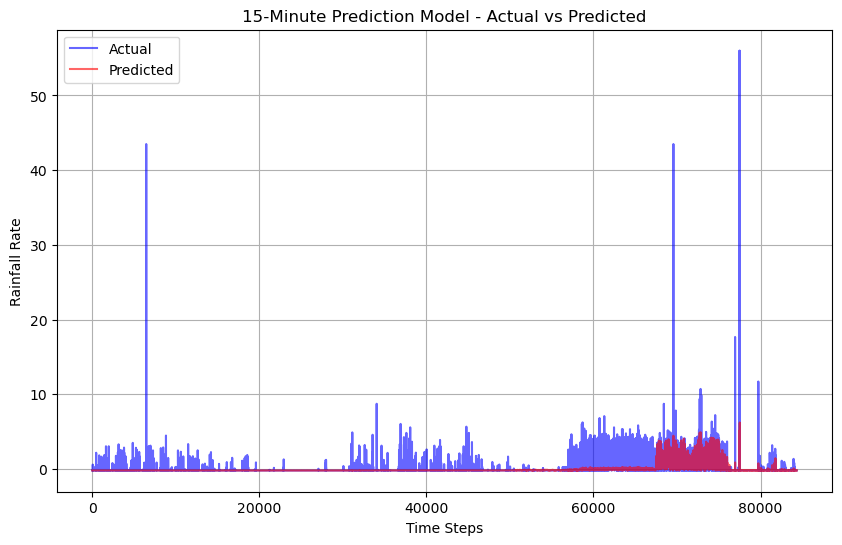

Epoch 1/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 1.3677 - val_loss: 0.6461
Epoch 2/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.3648 - val_loss: 0.2675
Epoch 3/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.0758 - val_loss: 0.1829
Epoch 4/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.0152 - val_loss: 0.1698
Epoch 5/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.0057 - val_loss: 0.1684
Epoch 6/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.0078 - val_loss: 0.1684
Epoch 7/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 0.0062 - val_loss: 0.1684
Epoch 8/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.0046 - val_loss: 0.1686
Epoch 9/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.0052 - val_loss: 0.1686
Epoch 10/50
445/528 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0101

In [ ]:
# Train and evaluate for 15-minute prediction (target: 1-hour prediction)
model_15min = train_and_evaluate(X_15min, y_15min, '15-Minute Prediction Model')

# Train and evaluate for 1-hour prediction (target: 1-hour prediction)
model_1hr = train_and_evaluate(X_1hr, y_1hr, '1-Hour Prediction Model')

# Train and evaluate for 2-hour prediction (target: 2-hour prediction)
model_2hr = train_and_evaluate(X_2hr, y_2hr, '2-Hour Prediction Model')